**Objetivo:** Explorar y analizar los datos limpios generados en la etapa de lectura.

- Revisar estructura general y dimensiones de los datasets  
- Analizar variables clave y su distribución  
- Identificar outliers, datos faltantes y relaciones relevantes  
- Generar visualizaciones exploratorias para apoyar el análisis  



In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones generales
pd.set_option("display.max_columns", None)
DATA_DIR = Path("data/clean_data/")

In [2]:
def plot_tipo_universidad_por_region(df, tipos_universidad, orden_regiones):
    """
    Gráfico de barras apiladas mostrando el porcentaje de tipos de universidad por región.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con las columnas 'cod_inst', 'region_sede' y 'tipo_inst_3'.
    tipos_universidad : list
        Lista con los tipos de universidad a filtrar.
    orden_regiones : list
        Lista con las regiones ordenadas de norte a sur.
    """

    # Filtrar datos y eliminar duplicados
    df_filtered = df[df['tipo_inst_3'].isin(tipos_universidad)].copy()
    df_filtered_unique = df_filtered.drop_duplicates(subset=['cod_inst', 'region_sede', 'tipo_inst_3'])

    # Ordenar regiones como categoría
    df_filtered_unique.loc[:, 'region_sede'] = pd.Categorical(
        df_filtered_unique['region_sede'], 
        categories=orden_regiones, 
        ordered=True
    )

    # Agrupar y calcular porcentaje
    df_grouped = df_filtered_unique.groupby(['region_sede', 'tipo_inst_3'], observed=True).size().unstack(fill_value=0)
    df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
    df_grouped = df_grouped.reindex(orden_regiones)

    # Definir colores
    default_colors = plt.cm.tab10.colors
    colores = {
        'Universidades Estatales CRUCH': default_colors[0],  # Azul
        'Universidades Privadas': default_colors[2],         # Verde
        'Universidades Privadas CRUCH': default_colors[1],   # Naranja
    }

    # Plot
    ax = df_grouped.plot(
        kind='barh',
        stacked=True,
        figsize=(10, 7),
        color=[colores[col] for col in df_grouped.columns]
    )

    ax.set_xlabel('Porcentaje')
    ax.set_ylabel('Región')
    ax.set_title('Porcentaje Tipo Universidad por Región')
    ax.legend(title='Tipo de Universidad', loc='center left', bbox_to_anchor=(1, 0.5))

    # Etiquetas de porcentaje dentro de las barras
    for p in ax.patches:
        width = p.get_width()
        if width > 0:
            ax.text(p.get_x() + width / 2, p.get_y() + p.get_height() / 2,
                    f'{round(width)}%', ha='center', va='center', color='white', fontsize=10)

    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


In [3]:

def plot_tipodepen_por_region(df, regiones_dict, tipodepen_dict, index_order):
    """
    Genera un gráfico de barras apiladas con el porcentaje de TIPO_DEPEN por región.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con columnas: 'NOM_RBD', 'COD_REG_RB' y 'TIPO_DEPEN'.
    regiones_dict : dict
        Diccionario para mapear ID de región a nombre.
    tipodepen_dict : dict
        Diccionario para mapear número de TIPO_DEPEN a nombre.
    index_order : list
        Lista con las regiones ordenadas de norte a sur.
    """

    # Filtrar y eliminar duplicados
    df_filtered = df.copy()
    df_filtered_unique = df_filtered.drop_duplicates(subset=['NOM_RBD', 'COD_REG_RB', 'TIPO_DEPEN'])

    # Agrupar y calcular porcentaje
    df_grouped = df_filtered_unique.groupby(['COD_REG_RB', 'TIPO_DEPEN'], observed=True).size().unstack(fill_value=0)
    df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100

    # Mapear nombres
    df_grouped.index = df_grouped.index.map(regiones_dict)
    df_grouped.columns = df_grouped.columns.map(tipodepen_dict)

    # Reordenar las regiones de norte a sur
    df_grouped = df_grouped.reindex(index_order[::-1])

    # Colores personalizados
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    # Crear gráfico
    fig, ax = plt.subplots(figsize=(16, 10))
    df_grouped.plot(kind='barh', stacked=True, color=colors, ax=ax)

    # Añadir porcentaje dentro de las barras
    for i, (index, row) in enumerate(df_grouped.iterrows()):
        cumulative = 0
        total = row.sum()
        for value in row:
            if value > 0.99:
                percentage = (value / total) * 100
                ax.text(cumulative + value / 2, i, f'{round(percentage)}%',
                        ha='center', va='center', color='white', fontsize=8, fontweight='bold')
            cumulative += value

    # Personalización
    ax.set_xlabel('Porcentaje (%)')
    ax.set_ylabel('Región')
    ax.set_title('Porcentaje de TIPO_DEPEN para cada región', fontsize=14)
    plt.yticks(rotation=0)
    plt.legend(title='TIPO_DEPEN', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [4]:


def plot_ivm_por_region(df, regiones_dict, index_order, valor_corte):
    """
    Gráfico de porcentaje de establecimientos con IVM mayor o igual al valor de corte por región.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con columnas: 'RBD', 'IVM_Establecimiento' y 'CODIGO_REGION_EGRESO'.
    regiones_dict : dict
        Diccionario para mapear ID de región a nombre.
    index_order : list
        Lista de nombres de regiones de norte a sur.
    valor_corte : float
        Valor mínimo de IVM para considerar en el análisis.
    """

    # Filtrar filas válidas y únicas por RBD
    df_filtrado = df.dropna(subset=['IVM_Establecimiento'])
    df_unico_rbd = df_filtrado.drop_duplicates(subset=['RBD'])

    # Filtrar los que cumplen la condición
    filtro = df_unico_rbd[df_unico_rbd['IVM_Establecimiento'] >= valor_corte]

    # Conteo por región
    conteo_filtrado = filtro.groupby('CODIGO_REGION_EGRESO').size().reset_index(name='Cumple_Condicion')
    conteo_total = df_unico_rbd.groupby('CODIGO_REGION_EGRESO').size().reset_index(name='Total_Observaciones')

    # Merge y cálculo de porcentaje
    resultado = pd.merge(conteo_filtrado, conteo_total, on='CODIGO_REGION_EGRESO', how='right')
    resultado['Porcentaje'] = (resultado['Cumple_Condicion'] / resultado['Total_Observaciones']) * 100

    # Mapear nombres de regiones
    resultado['Region_Nombre'] = resultado['CODIGO_REGION_EGRESO'].map(regiones_dict)

    # Ordenar las regiones
    resultado['Region_Nombre'] = pd.Categorical(resultado['Region_Nombre'], categories=index_order, ordered=True)
    resultado = resultado.sort_values('Region_Nombre')

    # Graficar
    plt.figure(figsize=(10, 6))
    bars = plt.barh(resultado['Region_Nombre'], resultado['Porcentaje'], color='skyblue')

    # Etiquetas
    for bar in bars:
        plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
                 f'{bar.get_width():.2f}%', va='center', ha='left', fontsize=10, color='black')

    plt.xlabel('Porcentaje (%)')
    plt.ylabel('Región')
    plt.title(f'Porcentaje de Establecimientos con IVM >= {valor_corte} por Región')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


In [5]:
def plot_matriz_movilidad(df, index_order):
    """
    Gráfico de heatmap mostrando la cantidad de estudiantes por región de origen y destino.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con las columnas 'NOMBRE_REGION_EGRESO' y 'NOMBRE_REGION_INGRESO'.
    index_order : list
        Lista de nombres de regiones en orden de norte a sur.
    """

    # Crear matriz de movilidad
    movilidad_matrix = pd.crosstab(
        df['NOMBRE_REGION_EGRESO'],
        df['NOMBRE_REGION_INGRESO']
    )

    # Reordenar filas y columnas
    movilidad_matrix = movilidad_matrix.reindex(index=index_order, columns=index_order, fill_value=0)

    # Crear Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(np.log1p(movilidad_matrix), cmap="Blues", annot=False, fmt="g")

    plt.xlabel("Región Destino Educación Superior")
    plt.ylabel("Región Origen Educación Media")
    plt.title("Mapa de Calor: Cantidad de Estudiantes por Región de Origen y Destino")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [6]:


def plot_boxplots_puntajes_por_movilidad(df, variables, labels=['No migró', 'Migró']):
    """
    Crea boxplots comparativos de puntajes por condición de movilidad.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame que contiene las columnas de puntajes y la columna 'MOVILIDAD'.

    variables : list
        Lista con los nombres de las columnas numéricas a graficar.

    labels : list
        Etiquetas personalizadas para la variable MOVILIDAD (por defecto: ['No migró', 'Migró']).
    """

    plt.style.use('ggplot')
    fig, axes = plt.subplots(1, len(variables), figsize=(5 * len(variables), 5))

    if len(variables) == 1:
        axes = [axes]  # Caso especial si solo hay una variable

    for i, var in enumerate(variables):
        sns.boxplot(x='MOVILIDAD', y=var, data=df, ax=axes[i])
        axes[i].set_title(f'Distribución de {var.replace("_", " ")} por Movilidad')
        axes[i].set_xticklabels(labels)
        axes[i].set_ylabel(var.replace("_", " "))

    plt.tight_layout()
    plt.show()


In [7]:
# Constante: Radio de la Tierra
R = 6371.0


def haversine(lat1, lon1, lat2, lon2):
    """Calcula la distancia entre dos puntos geográficos."""
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


def calcular_tasas_migracion(df):
    """Calcula tasas de migración y recepción por región."""
    df_migracion = df[['NOMBRE_REGION_EGRESO', 'NOMBRE_REGION_INGRESO']]

    total_egresados = df_migracion["NOMBRE_REGION_EGRESO"].value_counts()
    migrantes = df_migracion[df_migracion["NOMBRE_REGION_EGRESO"] != df_migracion["NOMBRE_REGION_INGRESO"]]["NOMBRE_REGION_EGRESO"].value_counts()
    tasa_migracion = (migrantes / total_egresados).fillna(0) * 100

    total_ingresados = df_migracion["NOMBRE_REGION_INGRESO"].value_counts()
    foraneos = df_migracion[df_migracion["NOMBRE_REGION_EGRESO"] != df_migracion["NOMBRE_REGION_INGRESO"]]["NOMBRE_REGION_INGRESO"].value_counts()
    tasa_recepcion = (foraneos / total_ingresados).fillna(0) * 100

    df_tasas = pd.DataFrame({
        "Tasa Migración (%)": tasa_migracion,
        "Tasa Recepción (%)": tasa_recepcion
    }).fillna(0).reset_index().rename(columns={'index': 'Región'})

    return df_tasas


def calcular_distancias(df):
    """Agrega columna DISTANCIA en base a Haversine y elimina filas NaN."""
    df['DISTANCIA'] = df.apply(
        lambda row: haversine(row['LATITUD_COL'], row['LONGITUD_COL'], row['LATITUD_UNI'], row['LONGITUD_UNI']),
        axis=1
    )
    df_filtrado = df.dropna(subset=['DISTANCIA'])
    print(f"Cantidad de observaciones: {df_filtrado.shape[0]}")
    return df_filtrado


def calcular_distancias_promedio(df_distancias, df_tasas):
    """Calcula distancia promedio de migración y recepción por región."""
    df_resultado = df_tasas.copy()
    df_resultado['DISTANCIA_PROMEDIO_MIGRACIÓN'] = 0.0
    df_resultado['DISTANCIA_PROMEDIO_RECEPCIÓN'] = 0.0

    migracion_count = {region: 0 for region in df_resultado['Región']}
    recepcion_count = {region: 0 for region in df_resultado['Región']}

    for _, row in df_distancias.iterrows():
        egreso = row['NOMBRE_REGION_EGRESO']
        ingreso = row['NOMBRE_REGION_INGRESO']
        distancia = row['DISTANCIA']

        if egreso != ingreso:
            if egreso in migracion_count:
                df_resultado.loc[df_resultado['Región'] == egreso, 'DISTANCIA_PROMEDIO_MIGRACIÓN'] += distancia
                migracion_count[egreso] += 1
            if ingreso in recepcion_count:
                df_resultado.loc[df_resultado['Región'] == ingreso, 'DISTANCIA_PROMEDIO_RECEPCIÓN'] += distancia
                recepcion_count[ingreso] += 1

    df_resultado['DISTANCIA_PROMEDIO_MIGRACIÓN'] = df_resultado.apply(
        lambda row: row['DISTANCIA_PROMEDIO_MIGRACIÓN'] / max(migracion_count.get(row['Región'], 1), 1), axis=1
    )

    df_resultado['DISTANCIA_PROMEDIO_RECEPCIÓN'] = df_resultado.apply(
        lambda row: row['DISTANCIA_PROMEDIO_RECEPCIÓN'] / max(recepcion_count.get(row['Región'], 1), 1), axis=1
    )

    return df_resultado


def plot_migracion_vs_distancia(df):
    """Grafica tasa de migración vs distancia promedio de migración."""
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(
        x='DISTANCIA_PROMEDIO_MIGRACIÓN',
        y='Tasa Migración (%)',
        data=df,
        color='blue',
        s=100,
        edgecolor='black'
    )

    for i in range(len(df)):
        scatter.text(df['DISTANCIA_PROMEDIO_MIGRACIÓN'].iloc[i],
                     df['Tasa Migración (%)'].iloc[i],
                     df['Región'].iloc[i],
                     fontsize=9, ha='right')

    plt.title('Tasa de Migración vs Distancia Promedio de Migración (km)', fontsize=16)
    plt.xlabel('Distancia Promedio de Migración (km)', fontsize=12)
    plt.ylabel('Tasa de Migración (%)', fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_tasa_vs_distancia(df, col_x, col_y, titulo, color='blue'):
    """
    Gráfico de dispersión genérico para tasas vs distancia promedio.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con los datos a graficar.

    col_x : str
        Nombre de la columna para el eje X (Distancia promedio).

    col_y : str
        Nombre de la columna para el eje Y (Tasa %).

    titulo : str
        Título del gráfico.

    color : str
        Color de los puntos del scatterplot.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    scatter = sns.scatterplot(
        x=col_x,
        y=col_y,
        data=df,
        color=color,
        s=100,
        edgecolor='black'
    )

    # Añadir etiquetas de texto con el nombre de la región
    for i in range(len(df)):
        scatter.text(
            df[col_x].iloc[i],
            df[col_y].iloc[i],
            df['Región'].iloc[i],
            fontsize=9,
            ha='right'
        )

    plt.title(titulo, fontsize=16)
    plt.xlabel(col_x.replace('_', ' '), fontsize=12)
    plt.ylabel(col_y, fontsize=12)
    plt.tight_layout()
    plt.show()


In [8]:
def agregar_distancia_promedio(df_tasas, df_distancias):
    """
    Agrega las columnas de distancia promedio de migración y recepción a df_tasas.

    Parámetros:
    -----------
    df_tasas : pd.DataFrame
        DataFrame con las tasas de migración y recepción (debe tener columna 'Región').

    df_distancias : pd.DataFrame
        DataFrame con las columnas 'NOMBRE_REGION_EGRESO', 'NOMBRE_REGION_INGRESO' y 'DISTANCIA'.

    Retorna:
    --------
    df_tasas2 : pd.DataFrame
        Copia de df_tasas con las columnas de distancia promedio agregadas.
    """

    df_tasas2 = df_tasas.copy()
    df_tasas2['Región'] = df_tasas2['Región'].astype(str)

    migracion_suma = df_distancias.groupby('NOMBRE_REGION_EGRESO')['DISTANCIA'].sum()
    recepcion_suma = df_distancias.groupby('NOMBRE_REGION_INGRESO')['DISTANCIA'].sum()

    migracion_count = df_distancias.groupby('NOMBRE_REGION_EGRESO').size()
    recepcion_count = df_distancias.groupby('NOMBRE_REGION_INGRESO').size()

    df_tasas2['DISTANCIA_PROMEDIO_MIGRACIÓN'] = df_tasas2['Región'].map(migracion_suma) / df_tasas2['Región'].map(migracion_count)
    df_tasas2['DISTANCIA_PROMEDIO_RECEPCIÓN'] = df_tasas2['Región'].map(recepcion_suma) / df_tasas2['Región'].map(recepcion_count)

    df_tasas2['DISTANCIA_PROMEDIO_MIGRACIÓN'] = df_tasas2['DISTANCIA_PROMEDIO_MIGRACIÓN'].fillna(0)
    df_tasas2['DISTANCIA_PROMEDIO_RECEPCIÓN'] = df_tasas2['DISTANCIA_PROMEDIO_RECEPCIÓN'].fillna(0)

    return df_tasas2


In [9]:


def plot_tasas_migracion_recepcion(df, orden_regiones):
    """
    Calcula y grafica las tasas de migración y recepción por región.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con columnas 'NOMBRE_REGION_EGRESO' y 'NOMBRE_REGION_INGRESO'.

    orden_regiones : list
        Lista con el orden de las regiones de norte a sur.
    """

    cols = ["NOMBRE_REGION_EGRESO", "NOMBRE_REGION_INGRESO"]
    df_migracion = df[cols]

    total_egresados = df_migracion["NOMBRE_REGION_EGRESO"].value_counts()
    migrantes = df_migracion[df_migracion["NOMBRE_REGION_EGRESO"] != df_migracion["NOMBRE_REGION_INGRESO"]]["NOMBRE_REGION_EGRESO"].value_counts()
    tasa_migracion = (migrantes / total_egresados).fillna(0) * 100

    total_ingresados = df_migracion["NOMBRE_REGION_INGRESO"].value_counts()
    foraneos = df_migracion[df_migracion["NOMBRE_REGION_EGRESO"] != df_migracion["NOMBRE_REGION_INGRESO"]]["NOMBRE_REGION_INGRESO"].value_counts()
    tasa_recepcion = (foraneos / total_ingresados).fillna(0) * 100

    df_tasas = pd.DataFrame({
        "Tasa Migración (%)": tasa_migracion,
        "Tasa Recepción (%)": tasa_recepcion
    }).fillna(0).reset_index().rename(columns={'index': 'Región'})

    df_tasas['Región'] = pd.Categorical(df_tasas['Región'], categories=orden_regiones, ordered=True)
    df_tasas = df_tasas.sort_values('Región')

    # Graficar
    plt.figure(figsize=(12, 8))
    bar_width = 0.35
    index = np.arange(len(df_tasas))

    bar1 = plt.barh(index - bar_width/2, df_tasas['Tasa Migración (%)'], bar_width,
                    color='#1f78b4', label='Tasa de Migración')
    bar2 = plt.barh(index + bar_width/2, df_tasas['Tasa Recepción (%)'], bar_width,
                    color='#ff7f0e', label='Tasa de Recepción')

    for p in bar1 + bar2:
        plt.annotate(f'{p.get_width():.1f}%', (p.get_width() + 1, p.get_y() + p.get_height()/2),
                    ha='left', va='center', fontsize=12, color='black')

    plt.title('Tasas de Migración y Recepción por Región', fontsize=16)
    plt.xlabel('Tasa (%)', fontsize=14)
    plt.ylabel('Región', fontsize=14)
    plt.yticks(index, df_tasas['Región'])
    plt.gca().invert_yaxis()
    plt.legend(title='Tasa', loc='lower right')
    plt.tight_layout()
    plt.show()


In [10]:
def preparar_datos_puntajes_movilidad(df, tipodepen_dict):
    """
    Prepara el DataFrame para análisis de puntajes y movilidad.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame original (set_abcde).

    tipodepen_dict : dict
        Diccionario para mapear tipo de dependencia.

    Retorna:
    --------
    df_puntajes_movilidad : pd.DataFrame
        DataFrame limpio y listo para graficar.
    """

    def convert_to_float(x):
        if isinstance(x, str):
            return float(x.replace(',', '.'))
        elif pd.isna(x):
            return np.nan
        else:
            return float(x)

    df_puntajes_movilidad = df.copy()

    # Crear variable MOVILIDAD (1 si migró, 0 si no)
    df_puntajes_movilidad['MOVILIDAD'] = (
        df_puntajes_movilidad['NOMBRE_REGION_EGRESO'] != df_puntajes_movilidad['NOMBRE_REGION_INGRESO']
    ).astype(int)

    # Convertir puntajes a numérico
    puntajes = ['PTJE_NEM', 'PTJE_RANKING', 'PROM_CM_ACTUAL']
    for col in puntajes:
        df_puntajes_movilidad[col] = df_puntajes_movilidad[col].apply(convert_to_float)

    # Mapear tipo de dependencia
    df_puntajes_movilidad['TIPO_DEPEN_NOMBRE'] = df_puntajes_movilidad['TIPO_DEPEN'].map(tipodepen_dict)

    print("Preparación de datos completada. DataFrame listo para análisis.")

    return df_puntajes_movilidad


In [11]:
def plot_boxplots_puntajes_por_movilidad(df, variables, labels=['No migró', 'Migró']):
    """
    Crea boxplots comparativos de puntajes por condición de movilidad.
    """
    plt.style.use('ggplot')
    fig, axes = plt.subplots(1, len(variables), figsize=(5 * len(variables), 5))

    if len(variables) == 1:
        axes = [axes]  # Caso especial si solo hay una variable

    for i, var in enumerate(variables):
        sns.boxplot(x='MOVILIDAD', y=var, data=df, ax=axes[i])
        axes[i].set_title(f'Distribución de {var.replace("_", " ")} por Movilidad')
        axes[i].set_xticklabels(labels)
        axes[i].set_ylabel(var.replace("_", " "))

    plt.tight_layout()
    plt.show()


In [12]:
def plot_puntajes_por_dependencia_movilidad(df):
    """
    Genera un gráfico con:
    - Boxplots de puntajes (NEM, Ranking, PDT) según tipo de dependencia y movilidad.
    - Porcentaje de movilidad por tipo de dependencia.

    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame preparado que contenga las columnas:
        - 'TIPO_DEPEN_NOMBRE'
        - 'MOVILIDAD'
        - 'PTJE_NEM'
        - 'PTJE_RANKING'
        - 'PROM_CM_ACTUAL'
    """

    plt.figure(figsize=(16, 10))

    # Gráfico 1: Puntaje NEM
    plt.subplot(2, 2, 1)
    sns.boxplot(x='TIPO_DEPEN_NOMBRE', y='PTJE_NEM', hue='MOVILIDAD',
                data=df, palette="Pastel1")
    plt.title('Puntaje NEM por Tipo de Dependencia', fontweight='bold')
    plt.xticks(rotation=45)
    plt.legend(title='Movilidad', labels=['No migró', 'Migró'])
    plt.ylabel('Puntaje NEM')

    # Gráfico 2: Puntaje Ranking
    plt.subplot(2, 2, 2)
    sns.boxplot(x='TIPO_DEPEN_NOMBRE', y='PTJE_RANKING', hue='MOVILIDAD',
                data=df, palette="Pastel1")
    plt.title('Puntaje Ranking por Tipo de Dependencia', fontweight='bold')
    plt.xticks(rotation=45)
    plt.legend(title='Movilidad', labels=['No migró', 'Migró'])
    plt.ylabel('Puntaje Ranking')

    # Gráfico 3: Promedio PDT
    plt.subplot(2, 2, 3)
    sns.boxplot(x='TIPO_DEPEN_NOMBRE', y='PROM_CM_ACTUAL', hue='MOVILIDAD',
                data=df, palette="Pastel1")
    plt.title('Promedio PDT por Tipo de Dependencia', fontweight='bold')
    plt.xticks(rotation=45)
    plt.legend(title='Movilidad', labels=['No migró', 'Migró'])
    plt.ylabel('Promedio PDT')

    # Gráfico 4: Porcentaje de Movilidad
    plt.subplot(2, 2, 4)
    movilidad_por_dependencia = df.groupby('TIPO_DEPEN_NOMBRE')['MOVILIDAD'].mean().sort_values() * 100
    movilidad_por_dependencia.plot(kind='bar', color=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    plt.title('Porcentaje de Movilidad por Tipo de Dependencia', fontweight='bold')
    plt.ylabel('Porcentaje que migró (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


In [13]:
# Lectura conjunto A
list(DATA_DIR.glob('*'))

[]

In [14]:
# Lectura de datos

year = 2021
DATA_DIR = Path(f"../data/clean/{year}")

# Buscar archivos
archivos = list(DATA_DIR.glob('set_*.csv'))

# Leer archivos y guardar en un diccionario
data = {
    archivo.stem: pd.read_csv(archivo)
    for archivo in archivos
}

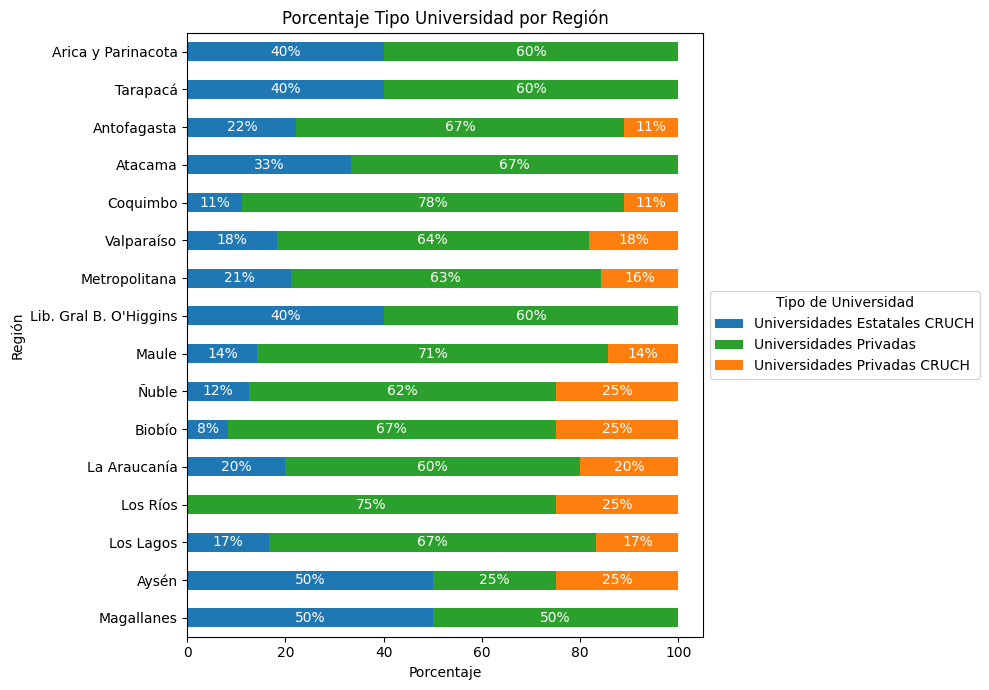

In [40]:
# usar la función
orden_regiones = [
    'Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama', 'Coquimbo',
    'Valparaíso', 'Metropolitana', "Lib. Gral B. O'Higgins", 'Maule', 'Ñuble',
    'Biobío', 'La Araucanía', 'Los Ríos', 'Los Lagos', 'Aysén', 'Magallanes'
]

tipos_universidad = [
    'Universidades Estatales CRUCH', 
    'Universidades Privadas', 
    'Universidades Privadas CRUCH'
]

plot_tipo_universidad_por_region(data['set_a'], tipos_universidad, orden_regiones)

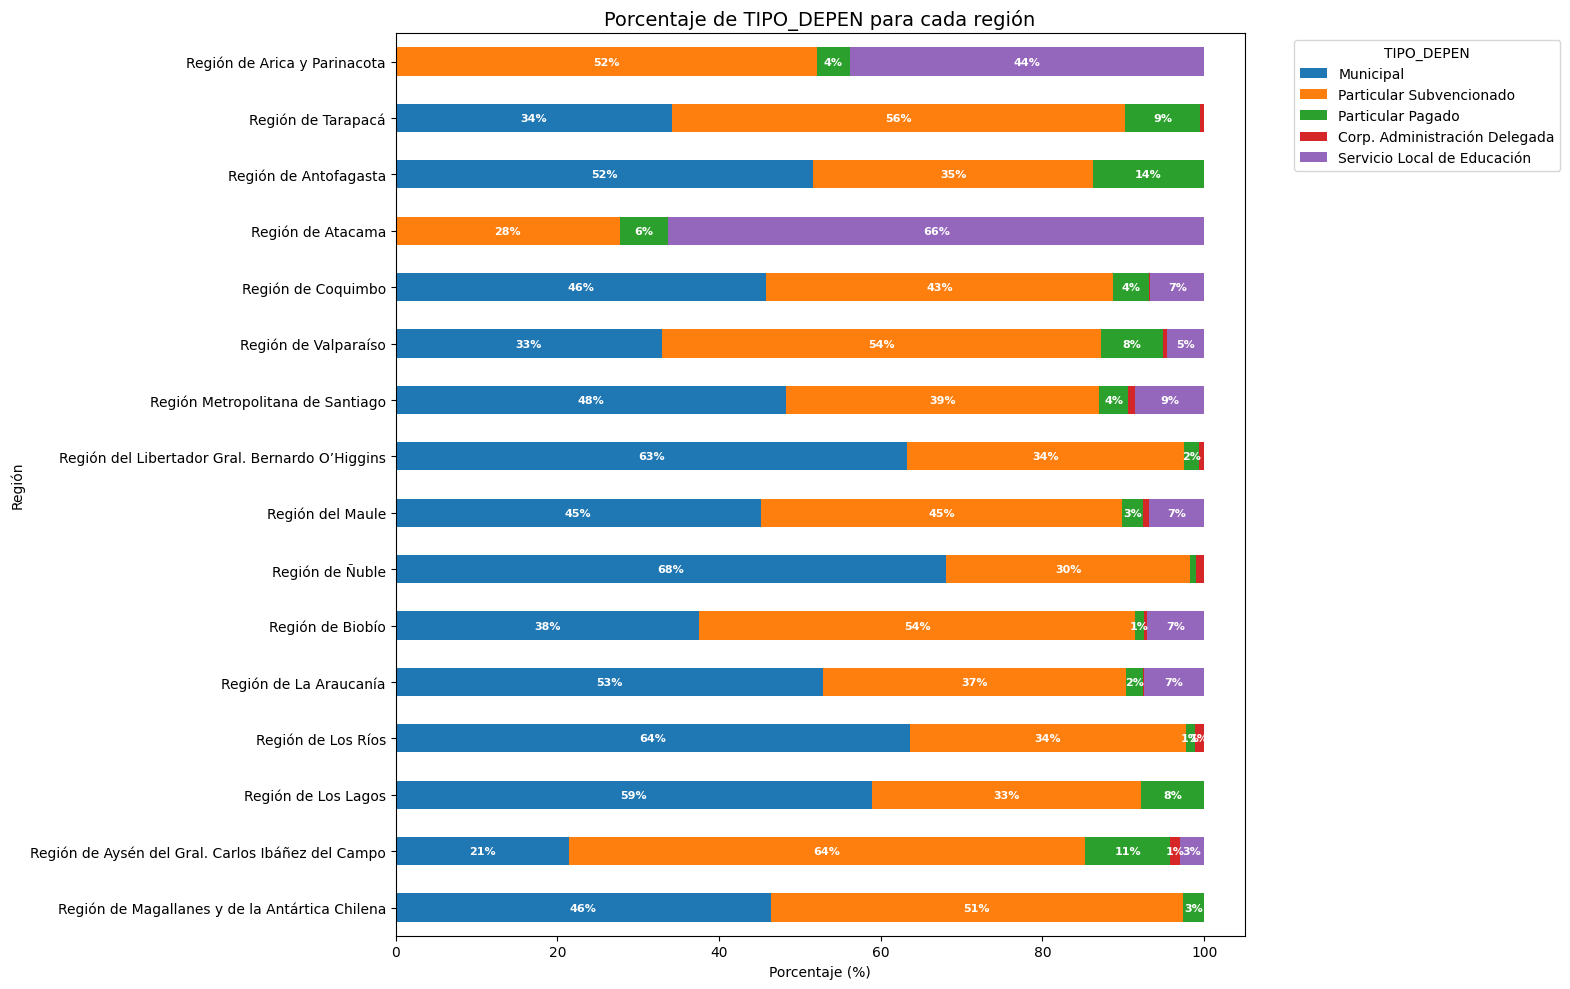

In [41]:
# Diccionario ID Región -> Nombre Región
regiones_dict = {
    1: 'Región de Tarapacá',
    2: 'Región de Antofagasta',
    3: 'Región de Atacama',
    4: 'Región de Coquimbo',
    5: 'Región de Valparaíso',
    6: 'Región Metropolitana de Santiago',
    7: 'Región del Libertador Gral. Bernardo O’Higgins',
    8: 'Región del Maule',
    9: 'Región de Biobío',
    10: 'Región de La Araucanía',
    11: 'Región de Los Ríos',
    12: 'Región de Los Lagos',
    13: 'Región de Aysén del Gral. Carlos Ibáñez del Campo',
    14: 'Región de Magallanes y de la Antártica Chilena',
    15: 'Región de Arica y Parinacota',
    16: 'Región de Ñuble'
}

# Diccionario TIPO_DEPEN -> Nombre
tipodepen_dict = {
    1: 'Municipal',
    2: 'Particular Subvencionado',
    3: 'Particular Pagado',
    4: 'Corp. Administración Delegada',
    5: 'Servicio Local de Educación'
}

# Orden de las regiones de norte a sur
index_order = [
    'Región de Arica y Parinacota',
    'Región de Tarapacá',
    'Región de Antofagasta',
    'Región de Atacama',
    'Región de Coquimbo',
    'Región de Valparaíso',
    'Región Metropolitana de Santiago',
    'Región del Libertador Gral. Bernardo O’Higgins',
    'Región del Maule',
    'Región de Ñuble',
    'Región de Biobío',
    'Región de La Araucanía',
    'Región de Los Ríos',
    'Región de Los Lagos',
    'Región de Aysén del Gral. Carlos Ibáñez del Campo',
    'Región de Magallanes y de la Antártica Chilena'
]


plot_tipodepen_por_region(
    df=data['set_c'],
    regiones_dict=regiones_dict,
    tipodepen_dict=tipodepen_dict,
    index_order=index_order
)

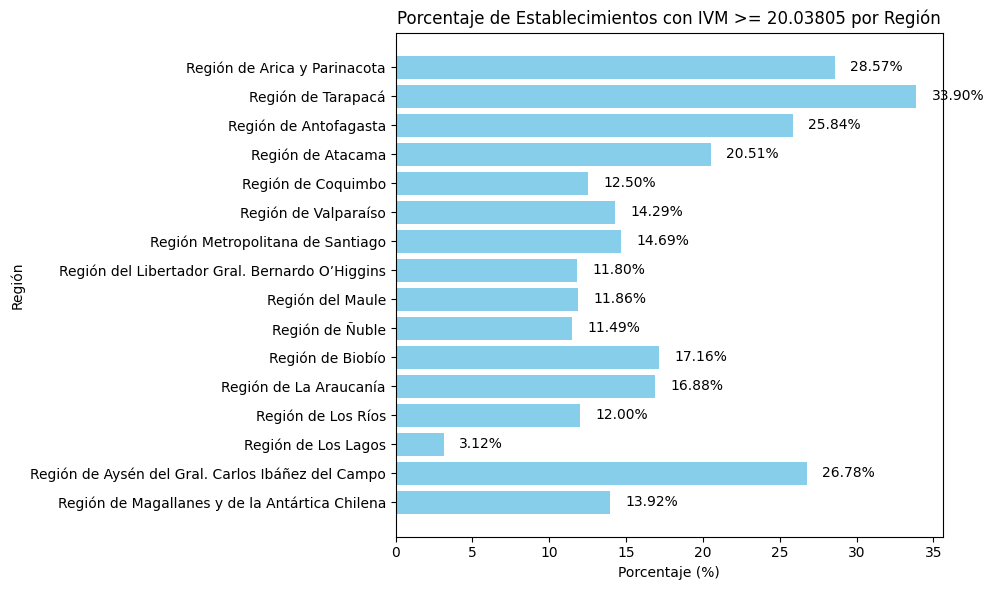

In [42]:
plot_ivm_por_region(
    df=data['set_abcde'],
    regiones_dict=regiones_dict,
    index_order=index_order,
    valor_corte=data['set_e']['valor_corte'][0]
)

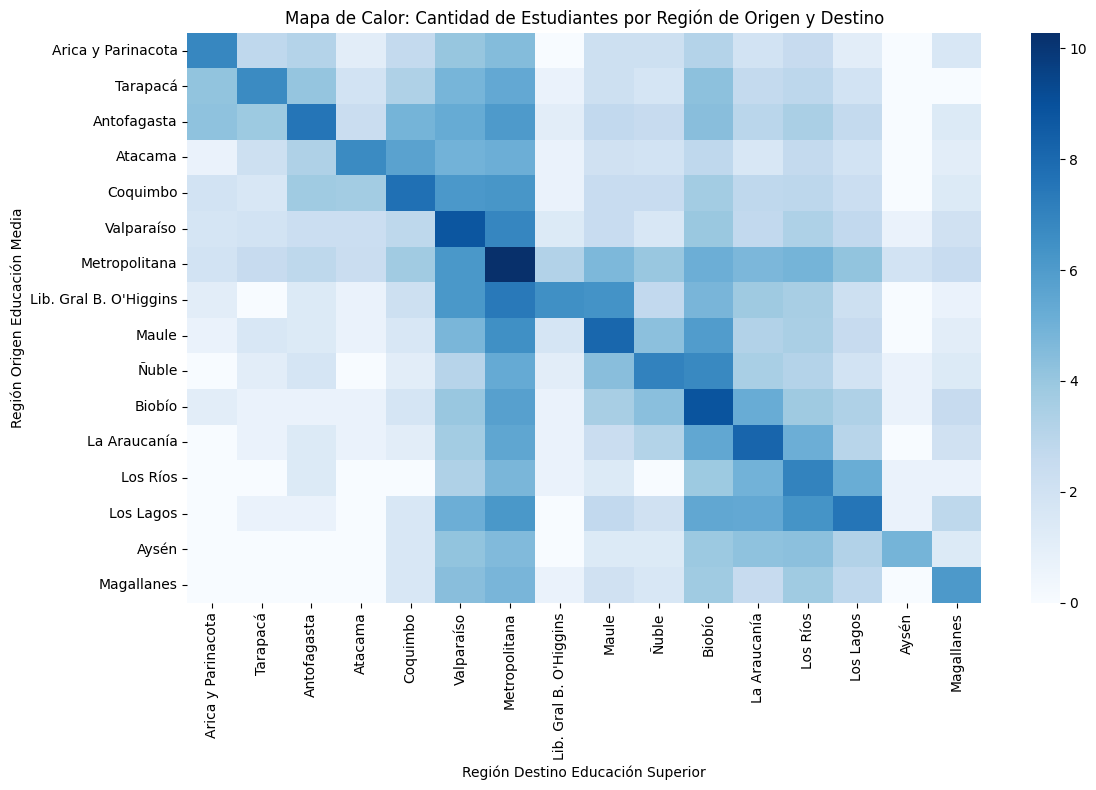

In [43]:
index_order = [
    'Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama', 'Coquimbo',
    'Valparaíso', 'Metropolitana', "Lib. Gral B. O'Higgins", 'Maule', 'Ñuble',
    'Biobío', 'La Araucanía', 'Los Ríos', 'Los Lagos', 'Aysén', 'Magallanes'
]

plot_matriz_movilidad(df=data['set_ab'], index_order=index_order)

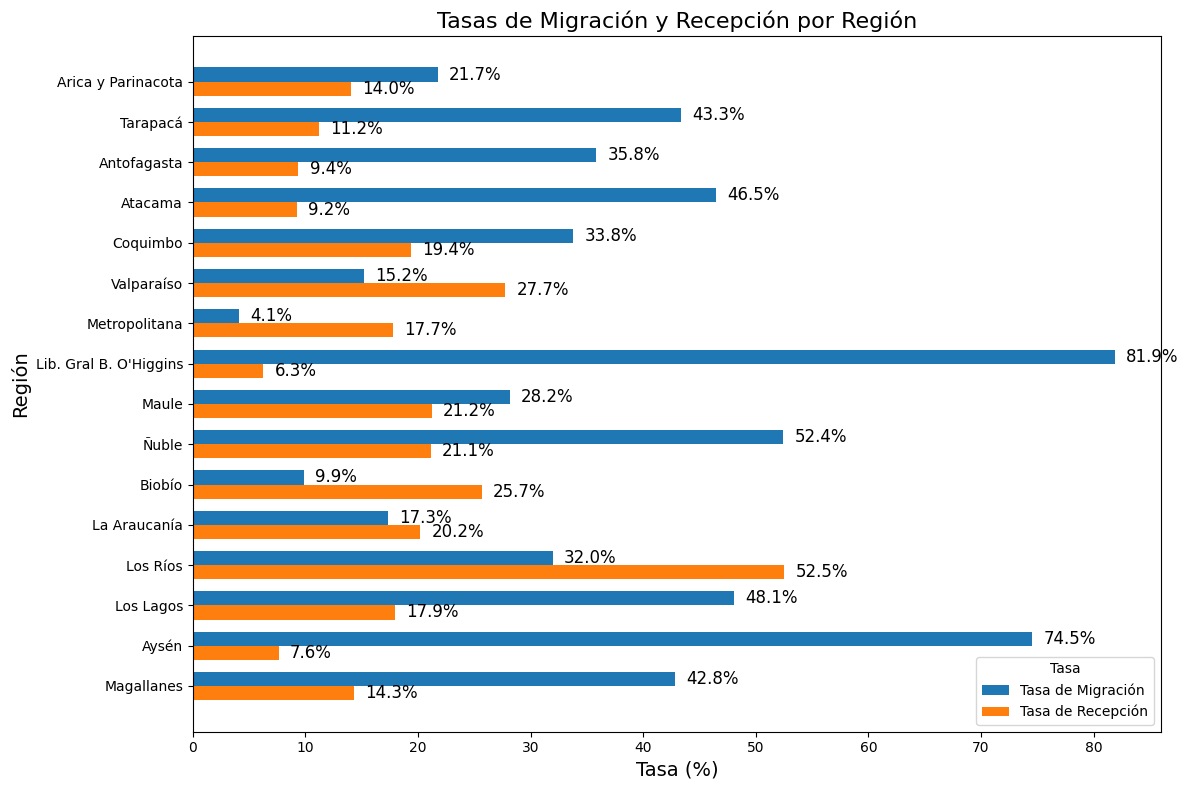

In [44]:
plot_tasas_migracion_recepcion(
    df=data['set_abcde'],
    orden_regiones=index_order  # <-- lista de tus regiones de norte a sur
)

Cantidad de observaciones: 60024


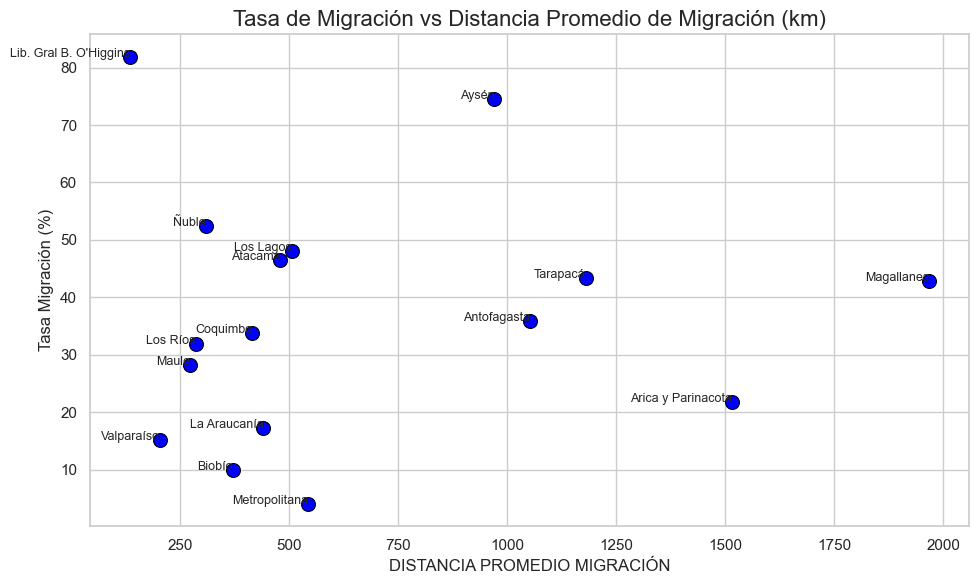

In [45]:
# Para migración:
# Paso 1: Calcular tasas de migración y recepción
df_tasas = calcular_tasas_migracion(data['set_abcde'])

# Paso 2: Calcular distancias entre colegios y universidades
set_abcde3 = calcular_distancias(data['set_abcde'])

# Paso 3: Calcular distancias promedio
df_tasas2 = calcular_distancias_promedio(set_abcde3, df_tasas)
plot_tasa_vs_distancia(
    df=df_tasas2,
    col_x='DISTANCIA_PROMEDIO_MIGRACIÓN',
    col_y='Tasa Migración (%)',
    titulo='Tasa de Migración vs Distancia Promedio de Migración (km)',
    color='blue'
)


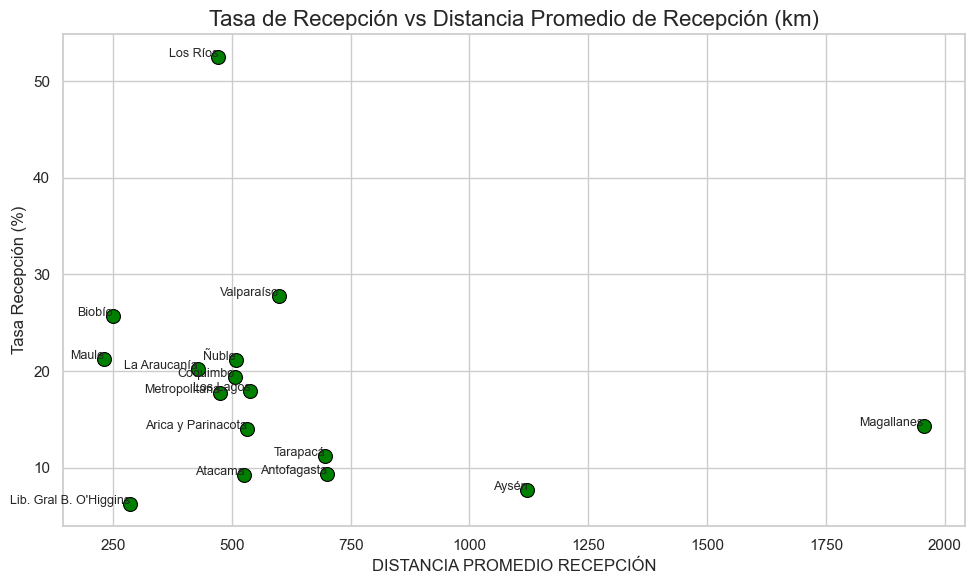

In [46]:
# Para recepción:
plot_tasa_vs_distancia(
    df=df_tasas2,
    col_x='DISTANCIA_PROMEDIO_RECEPCIÓN',
    col_y='Tasa Recepción (%)',
    titulo='Tasa de Recepción vs Distancia Promedio de Recepción (km)',
    color='green'
)


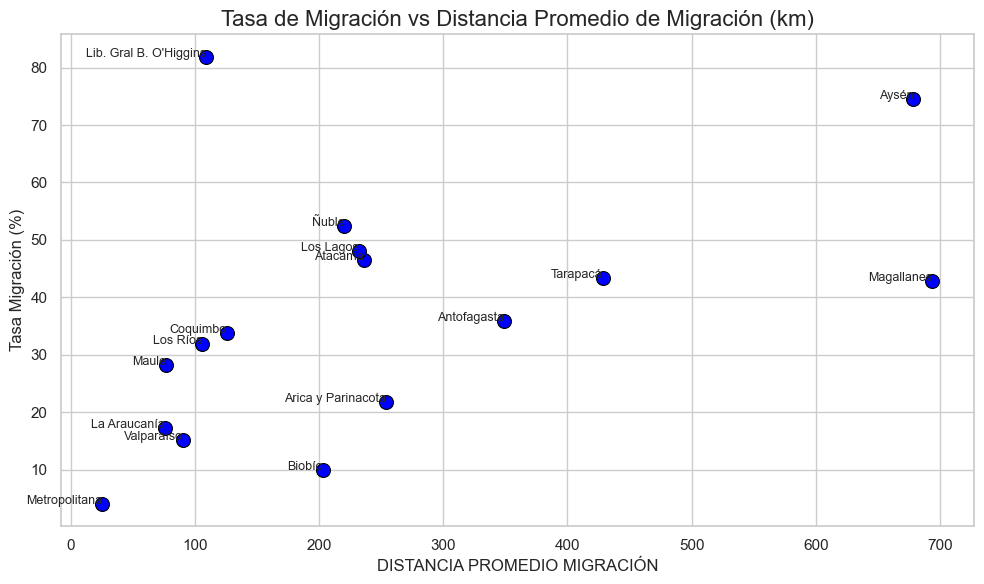

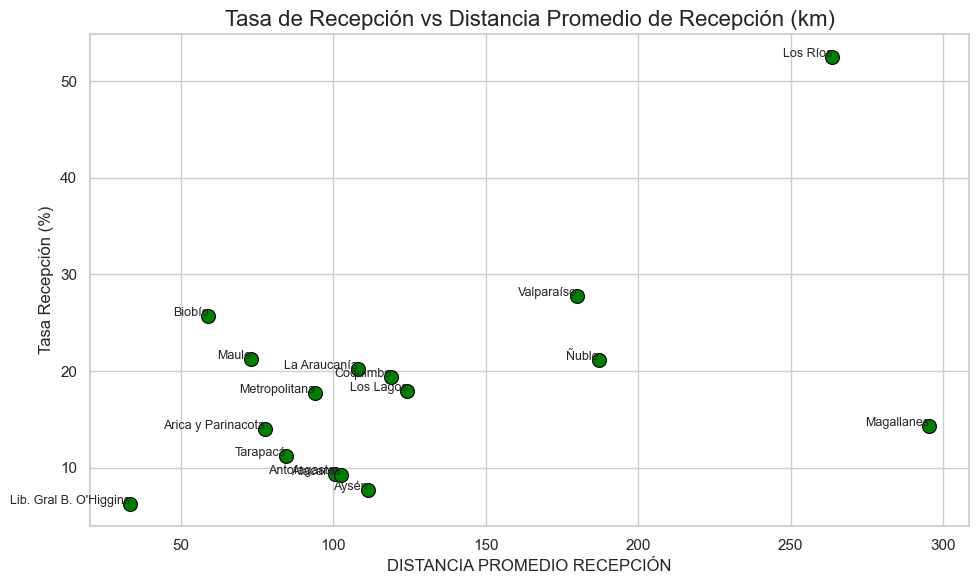

In [47]:
# Calcular distancias promedio
df_tasas2 = agregar_distancia_promedio(df_tasas, set_abcde3)

# Graficar migración
plot_tasa_vs_distancia(
    df=df_tasas2,
    col_x='DISTANCIA_PROMEDIO_MIGRACIÓN',
    col_y='Tasa Migración (%)',
    titulo='Tasa de Migración vs Distancia Promedio de Migración (km)',
    color='blue'
)

# Graficar recepción
plot_tasa_vs_distancia(
    df=df_tasas2,
    col_x='DISTANCIA_PROMEDIO_RECEPCIÓN',
    col_y='Tasa Recepción (%)',
    titulo='Tasa de Recepción vs Distancia Promedio de Recepción (km)',
    color='green'
)


Preparación de datos completada. DataFrame listo para análisis.


C:\Users\franc\AppData\Local\Temp\ipykernel_19132\3308335394.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(labels)
C:\Users\franc\AppData\Local\Temp\ipykernel_19132\3308335394.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(labels)
C:\Users\franc\AppData\Local\Temp\ipykernel_19132\3308335394.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(labels)


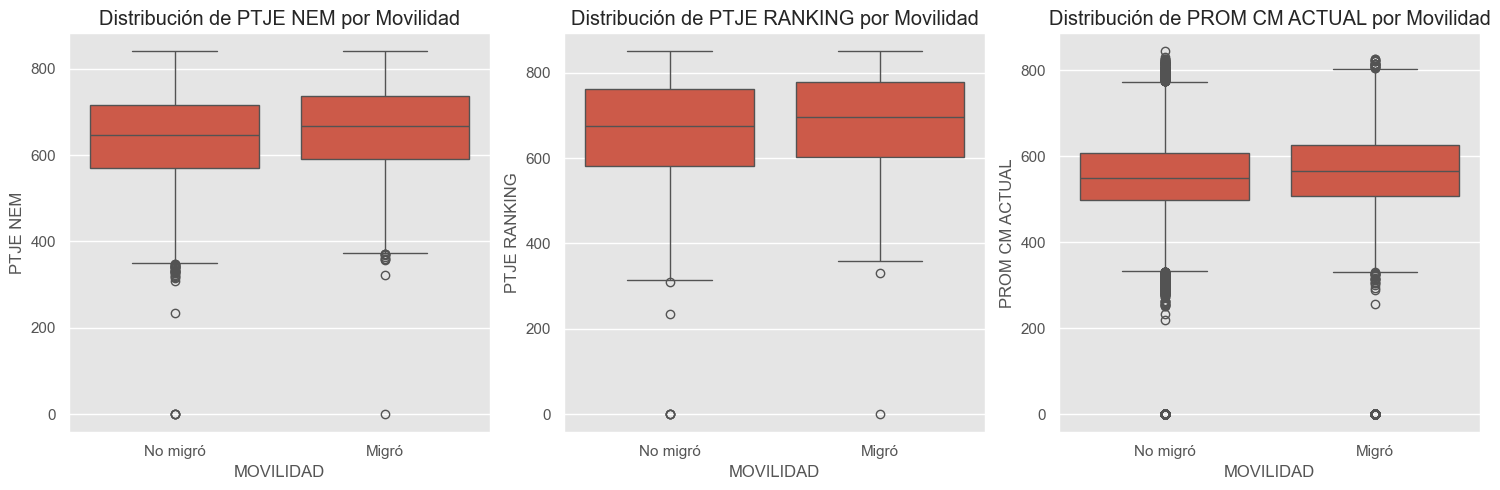

In [48]:
# Preparar datos
df_puntajes_movilidad = preparar_datos_puntajes_movilidad(data['set_abcde'], tipodepen_dict)

# Graficar puntajes
plot_boxplots_puntajes_por_movilidad(
    df=df_puntajes_movilidad,
    variables=['PTJE_NEM', 'PTJE_RANKING', 'PROM_CM_ACTUAL']
)

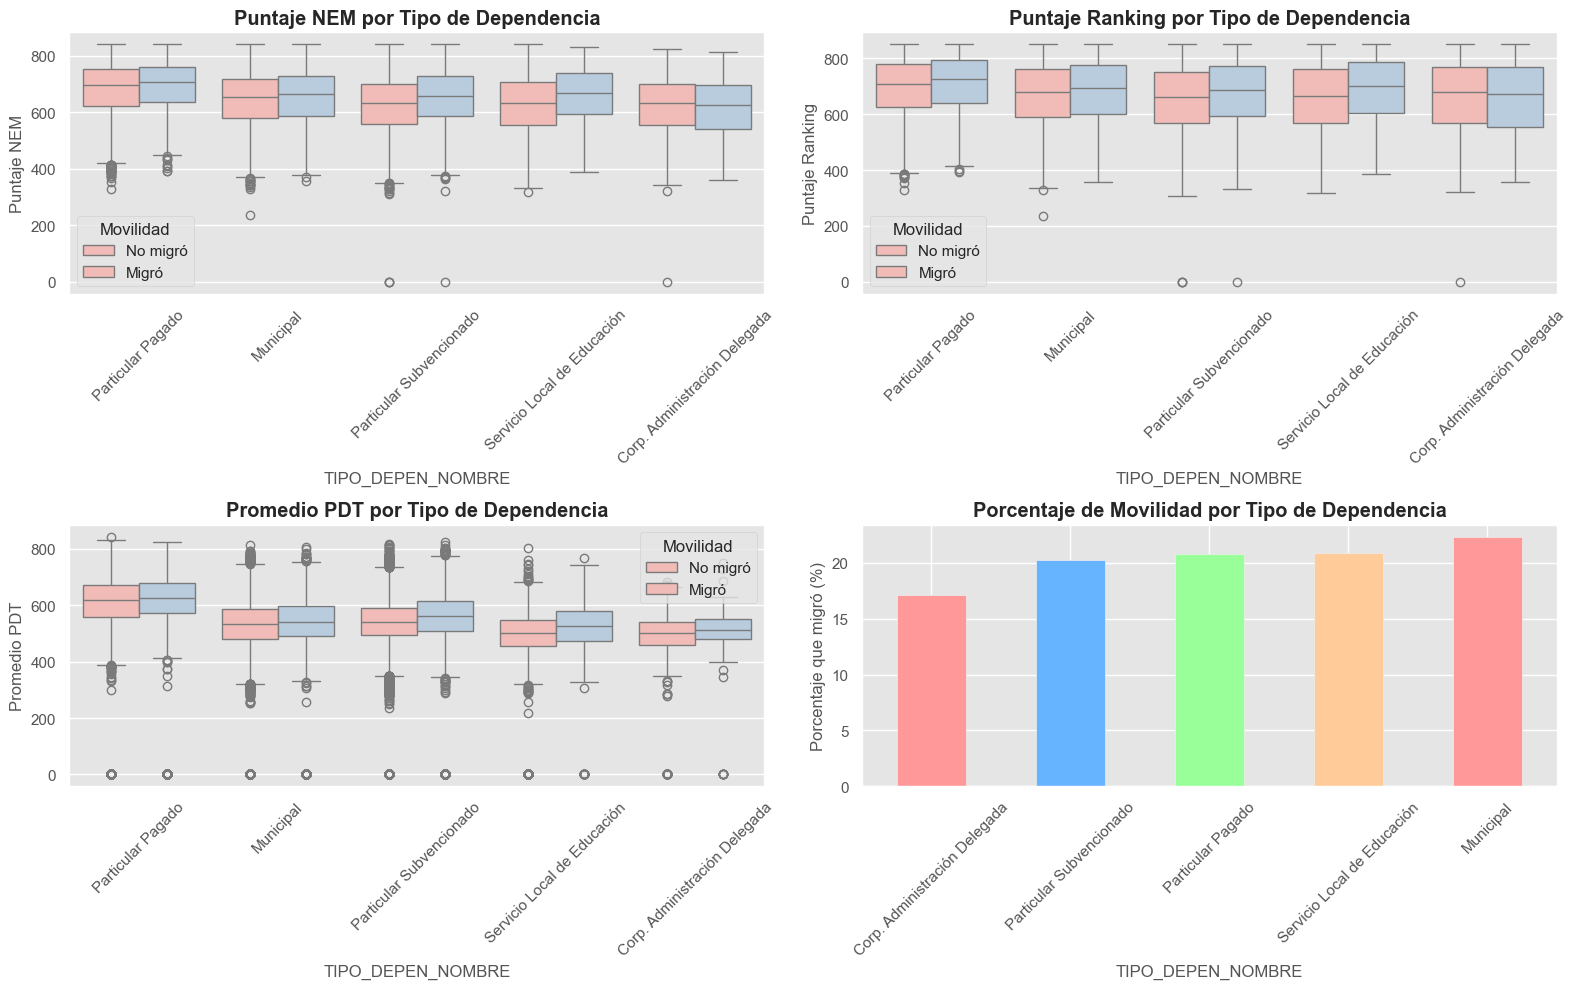

In [49]:
plot_puntajes_por_dependencia_movilidad(df_puntajes_movilidad)